In [6]:
import numpy as np
from scipy.stats import norm, binom, spearmanr
import seaborn as sns
import pandas as pd

import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib as mpl
import jax.numpy as jnp
import jax
from jax.lax import cond
import scipy.optimize as opt
from jax.scipy.special import expit, logit, xlogy
from scipy.special import comb
import os
from ipywidgets import interact, FloatSlider, Dropdown
import ipywidgets as widgets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

cpu_device = jax.devices("cpu")
jax.config.update("jax_platform_name", "cpu")
fontx=12
fonty=12

In [7]:
@jax.jit
def compute_t_2D(ρ, α, β):
    FDR = (1 - 2 * α + 2 * ρ) / (2 * (1 - 2 * α))  # eq 3a
    return 1 - FDR

@jax.jit
def compute_t_3D(ρ, α, β):
    Δ = 4 * α * α - 4 * α + 4 * β * β + 1 + 8 * β * ρ
    FDR = (2 * α + 2 * β - 1 + jnp.sqrt(Δ)) / (4 * β)  # eq 3
    return 1 - FDR

@jax.jit   
def compute_t(ρ, α, β):
    """Generate t - the true incidence of left-handedness

    From Laland at al., (1995):
    F_DR is the final equilibrium frequency of right-handers with allele D fixed
    We need F_DL = 1 - F_DR
    """
    return cond(jnp.isclose(β, 0), compute_t_2D, compute_t_3D, ρ, α, β)    


@jax.jit   
def validate(θ):
    if len(θ) == 3: # when estimating all three parameters (ρ, α, β)
        ρ, α, β = θ
    elif len(θ) == 2:   # when estimating ρ, α - fix β to zero
        ρ, α = θ
        β = 0
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))

    unvalid = (ρ < 0) | (ρ > 1) | (α < 0) | (α > 1) | (β < 0) | (β > 1) | (ρ + α >= 0.5) | (ρ - α > 0.5) | (ρ + β > 0.5) # model constrain of parameters
    return jnp.logical_not(unvalid)
##################################################
### MATRICES


@jax.jit   
def compute_T(ρ, α, β):
    """Generate T - column DD in Table 1

    From Appendix 3:
    T is a 3 x 2 matrix of p(Ht | Ht x Ht) entries -
    probability of a truly H child from a mating where parents are truly H
    """
    return jnp.array([
        # R           L
        [0.5 + ρ + α, 1 - (0.5 + ρ + α)],  # RxR
        [0.5 + ρ + β, 1 - (0.5 + ρ + β)],  # RxL
        [0.5 + ρ - α, 1 - (0.5 + ρ - α)]  # LxL
    ])


@jax.jit   
def compute_P_gt(mp,t):
    u = (mp - t) / mp  # The proportion of individuals measured as left handers that are truly right handers

    # The matrix P is given by:
    P = jnp.array([
        [1, 0, 0],
        [u, 1 - u, 0],
        [u * u, 2 * u * (1 - u), (1 - u) * (1 - u)]
    ])
    return P


@jax.jit   
def compute_P_le(mp, t):
    v = (t - mp) / (1 - mp)  # The proportion of individuals measured as right handed who are truly left handed
    # The matrix P is given by:
    P = jnp.array([
        [(1 - v) * (1 - v), 2 * v * (1 - v), v * v],
        [0, 1 - v, v],
        [0, 0, 1]
    ])
    return P


@jax.jit   
def compute_P(mp, t):
    """ Parents generation:
    The matrix P gives the probability that a mating measured as RxR, RxL, or LxL is truly RxR, RxL, or LxL"""
    return cond(mp > t, compute_P_gt, compute_P_le, mp, t)


@jax.jit   
def compute_O_gt(mo, t):
    w = (mo - t) / (1 - t)  # The proportion of individuals measured as left handers that are truly right handers
    # The matrix O is given by:
    O = jnp.array([
        [1 - w, w],
        [0, 1]
    ])
    return O


@jax.jit   
def compute_O_le(mo, t):
    x = 1 - (mo / t)  # The proportion of individuals measured as right handed who are truly left handed
    # The matrix O is given by:
    O = jnp.array([
        [1, 0],
        [x, 1 - x]
    ])
    return O
    

@jax.jit   
def compute_O(mo, t):
    """ Offspring generation:
    The matrix O gives the probability of offspring measured as right or left handed given that it is truly right or left handed """

    return cond(mo > t, compute_O_gt, compute_O_le, mo, t)


@jax.jit   
def compute_M(T, P, O):
    M = P @ T @ O
    return M
##################################################
# Likelihood functions


@jax.jit   
def n_log_likelihood_St(θ, data):  # using the function Sm
    # Check the length of θ to unpack the parameters accordingly
    if len(θ) == 3:
        ρ, α, β = θ
    elif len(θ) == 2:
        ρ, α = θ
        β = 0  # Default value for β if not provided
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))  # Raise error if length of θ is not 2 or 3

    # Validate the parameters θ
    return -cond(
        validate(θ), 
        log_likelihood_St_validated, 
        lambda ρ, α, β, data: -jnp.inf,  # Return infinity if θ is not valid
        ρ, α, β, data
    )


@jax.jit   
def log_likelihood_St_validated(ρ, α, β, data):
    St = 0.0  # Initialize log-likelihood sum

    # Compute T and t using the provided functions and parameters
    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)

    # Estimation using the matrix M:

    # Loop through each dataset in Data
    for index, dataset in enumerate(data):
        # Sum up the log-likelihood for the current dataset
        St += jnp.nansum(xlogy(dataset, T.flatten()))

    return St  # Return the computed log-likelihood sum



@jax.jit   
def n_log_likelihood_Sm(θ, data, mo, mp):  # using the function Sm

    # Check the length of θ to unpack the parameters accordingly
    if len(θ) == 3:
        ρ, α, β = θ
    elif len(θ) == 2:
        ρ, α = θ
        β = 0  # Default value for β if not provided
    else:
        raise ValueError("Length of θ is {}".format(len(θ)))  # Raise error if length of θ is not 2 or 3

    # Validate the parameters θ
    return -cond(
        validate(θ), 
        log_likelihood_Sm_validated, 
        lambda ρ, α, β, data, mo, mp: -jnp.inf,  # Return infinity if θ is not valid
        ρ, α, β, data, mo, mp
    )


@jax.jit   
def log_likelihood_Sm_validated(ρ, α, β, data, mo, mp):
    Sm = 0.0  # Initialize log-likelihood sum

    # Compute T and t using the provided functions and parameters
    T = compute_T(ρ, α, β)
    t = compute_t(ρ, α, β)

    # Estimation using the matrix M:

    # Loop through each dataset in Data
    for index, dataset in enumerate(data):
        # jax.debug.print("Sm={Sm}", Sm=Sm)
        # Retrieve mp and mo indices for the current dataset

        mp_idx = mp[index]
        mo_idx = mo[index]


        # Compute P and O using the provided functions and mp, mo indices
        P = compute_P(mp_idx, t)

        O = compute_O(mo_idx, t)

        # Compute matrix M using T, P, and O
        M = compute_M(T, P, O)

        # Sum up the log-likelihood for the current dataset
        Sm += jnp.nansum(xlogy(dataset, M.flatten()))

    return Sm  # Return the computed log-likelihood sum


def fit(n_parameters, data, adjust, mo=None, mp=None):
    """
    Fit the model parameters to the given data.

    Parameters:
    n_parameters (int): The number of parameters to estimate.
    data (list or numpy.ndarray): The dataset to fit the model to.
    adjust (bool): If True, use the Sm function; if False, use the St function.

    Returns:
    tuple: Estimated parameters (θ_hat) and the maximum log-likelihood (logL).
    """
    
    
    if adjust:
        # Minimize negative log-likelihood using the Sm function
        result  = sorted([opt.minimize(lambda x: n_log_likelihood_Sm(x, data, mo, mp), x0=[0.1, 0.1, 0.1][:n_parameters], method="Nelder-Mead"), 
                          opt.minimize(lambda x: n_log_likelihood_Sm(x, data, mo, mp), x0=[0.01, 0.1, 0.1][:n_parameters], method="Nelder-Mead"),
                          opt.minimize(lambda x: n_log_likelihood_Sm(x, data, mo, mp), x0=[0.1, 0.01, 0.1][:n_parameters], method="Nelder-Mead"),
                          opt.minimize(lambda x: n_log_likelihood_Sm(x, data, mo, mp), x0=[0.45, 0.01, 0][:n_parameters], method="Nelder-Mead"),
                          opt.minimize(lambda x: n_log_likelihood_Sm(x, data, mo, mp), x0=[0.01, 0.45, 0][:n_parameters], method="Nelder-Mead")], key=lambda x: x.fun)[0]

                              
                          
        
    else:
        # Minimize negative log-likelihood using the St function
        result  = sorted([opt.minimize(lambda x: n_log_likelihood_St(x, data), x0=[0.1, 0.1, 0.1][:n_parameters], method="Nelder-Mead"), 
                          opt.minimize(lambda x: n_log_likelihood_St(x, data), x0=[0, 0.1, 0.1][:n_parameters], method="Nelder-Mead"),
                          opt.minimize(lambda x: n_log_likelihood_St(x, data), x0=[0.1, 0, 0.1][:n_parameters], method="Nelder-Mead"),
                          opt.minimize(lambda x: n_log_likelihood_St(x, data), x0=[0.45, 0.01, 0][:n_parameters], method="Nelder-Mead"),
                          opt.minimize(lambda x: n_log_likelihood_St(x, data), x0=[0.01, 0.45, 0][:n_parameters], method="Nelder-Mead")], key=lambda x: x.fun)[0]

    
    return result.x

def family_probs(ρ, α, β, size):
    probs = []
    T = compute_T(ρ, α, β)

    for mating in range(3):
        pr = T[mating][0]
        p = [(comb(size, i) * pr ** (size-i) * (1-pr) ** i) for i in range(size+1)]
        probs.append(p)
    return np.array(probs)


## Generate Synthetic data

In [8]:
def create_fam_population(ρ, α, β, t, size):
    """
    Create population (for 1 datset) of families given the model paramethers
    :param ρ: Allele D effect.
    :type ρ: float.
    :param α: RxR parents effect.
    :type α: float.
    :param t: left-handedness rate.
    :param size: The number of families in the dataset.
    :type size: int.
    """

    # calculate the rate of allele C in population

    population = []
    parents = binom.rvs(p=t, n=2, size=size)

    ### For each family generate children ###

    for i in range(size):
        fam_size = binom.rvs(p=0.354, n=4) + 1
        p_type = parents[i]
        prob = family_probs(ρ, α, β, fam_size)[p_type]
        l = np.random.choice(range(1 + fam_size), p=prob)
        population.append(np.array([p_type, fam_size, l]))

    return np.array(population)


In [9]:

def true_to_measured_fam(population, t):
    """
    Add to population (for 1 datset) bias to simulate criterion shift

    :param population: The population we want to add bias to.
    :type t: array.
    :param t: p(L_t) - The true incidence of left-handedness.
    :type t: float
    """

    # Using laland(1995) observed rate of left handedness, and the model (t=0.1174) create bank of observed rates for the new pl
    measured = t * np.array([.1556, 0.0803, 0.0477, 0.0356, 0.0877, 0.0524, 0.2363, 0.1553, 0.1063, 0.0440, 0.0976, 0.0986, 0.0831,
                              0.093,  0.1407, 0.1040, 0.0850, 0.0547, 0.132,  0.076,  0.1838, 0.0838, 0.2457, 0.1802, 0.1059, 0.0811, 
                              0.1105, 0.1628, 0.0739, 0.1364, 0.0465, 0.0698, 0.0455, 0.0505,
                              0.1071, 0.9520, 0.19,   0.1885, 0.1188, 0.1844, 0.1282, 0.2424, 0.1332, 0.1711, 0.1410, 0.1667, 0.1512,
                              0.1138, 0.1064, 0.11,   0.1714, 0.1541, 0.1627, 0.1161, 0.1969, 0.1089, 0.1931, 0.1111, 0.1596, 0.1477]) / 0.1174

    # Choose observed rate for the parents and for offspring
    parent, offspring = np.random.choice(measured, size=2, replace=True)

    parent = min(1, parent)
    offspring = min(1, offspring)

    # Calculate p(Rm|Lt) and p(Lm|Rt) using the rates chosen and pl
    if parent > t:
        pRL_parent = 0
        pLR_parent = (parent - t) / (1 - t)
    else:
        pRL_parent = 1 - (parent / t)
        pLR_parent = 0

    if offspring > t:
        pRL_offspring = 0
        pLR_offspring = (offspring - t) / (1 - t)
    else:
        pRL_offspring = 1 - (offspring / t)
        pLR_offspring = 0

    # Shift the population using calculated probabilities
    for i in range(len(population)):

        parents, children, lefts = population[i]

        if parents == 0:
            new_parents = int((np.random.random() < pLR_parent)) + int((np.random.random() < pLR_parent))

        elif parents == 1:
            new_parents = int((np.random.random() < pLR_parent)) + int((np.random.random() < (1 - pRL_parent)))

        else:
            new_parents = int((np.random.random() < (1 - pRL_parent))) + int((np.random.random() < (1 - pRL_parent)))

        new_child = binom.rvs(p=(1 - pRL_offspring), n=lefts) + binom.rvs(p=pLR_offspring, n=(children - lefts))

        population[i, 0] = new_parents
        population[i, 2] = new_child

    return population


In [10]:
def fam_pop_to_datasets(populations):
    """
    Convert the populations to family datasets

    :param population: populations of families.
    :type population: list.
    """

    data = []
    measured = []

    for population in populations:

        # calculate the measured rates of left-handedness

        measured.append(np.array(
            [np.sum(population[:, 2]) / np.sum(population[:, 1]), np.sum(population[:, 0]) / (2 * len(population))]))

        # Convert to triplets
    
        ds = np.zeros(6)
        for family in population:
            couple_type, fam_size, left_children = family
            ds[2 * couple_type] += fam_size - left_children
            ds[2 * couple_type + 1] += left_children
        data.append(ds)
    return np.array(data).reshape(-1, np.array(data).shape[-1]), np.array(measured)


In [11]:
def fam_pop_to_multi_datasets(populations):
    """
    Convert the populations to family datasets

    :param population: populations of families.
    :type population: list.
    """

    data = []
    measured = []

    for population in populations:

        # calculate the measured rates of left-handedness

        measured.append(np.array(
            [np.sum(population[:, 2]) / np.sum(population[:, 1]), np.sum(population[:, 0]) / (2 * len(population))]))

        # Convert to triplets
    
        
        ds = np.zeros((5, 18))
        for family in population:
            couple_type, fam_size, left_children = family
            ds[fam_size - 1, 6 * couple_type + left_children] += 1

        for size in range(5):
            for cnt in range(size + 2, 6):
                ds[size, cnt] = np.nan
                ds[size, 6 + cnt] = np.nan
                ds[size, 12 + cnt] = np.nan
        data.append(ds)
    return np.array(data).reshape(-1, np.array(data).shape[-1]), np.array(measured)


In [12]:
def multi_datasets_to_fam_pop(datasets):
    """
    Convert from multi table to populations

    :param datasets: datasets of families.
    :type datasets: list.
    """

    populations = []
    total_fams = 0
    total_offspring = 0
    l_total_parents = 0
    l_total_offspring = 0

    for i in range(len(datasets)//5):
        population = []
        ds = datasets[i*5:(i+1)*5]
        for size in range(5):
            for l in range(6):
                population += [[0, size+1, l] for _ in range(int(np.nansum(ds[size, l])))]
                population += [[1, size+1, l] for _ in range(int(np.nansum(ds[size, 6+l])))]
                population += [[2, size+1, l] for _ in range(int(np.nansum(ds[size, 12+l])))]
        population = np.array(population)
        populations.append(population)

        l_total_parents = np.sum(population[:,0])
        total_fams = len(population)

        l_total_offspring = np.sum(population[:,2])
        total_offspring = np.sum(population[:,1])
    
    return populations, 0.5*l_total_parents/total_fams, l_total_offspring/total_offspring

In [13]:
def resample(data):
    """
    Bootstrap data
    """

    new_data = []

    for ds in data:
        size = len(ds)
        idxes = np.random.choice(range(size), size=size, replace=True)
        new_ds = ds[idxes]
        new_data.append(new_ds)


    return fam_pop_to_datasets(new_data)


In [14]:
def generate_datasets(ρ, α, β, t, par=0, adjust=False):
    np.random.seed()
    if (par % 100 == 0):
        print(f"  {par}  ")
    os.makedirs(f"data/{adjust}", exist_ok=True)

    # Create triplets table:
    if adjust:
        triplets_data = [true_to_measured_fam(create_fam_population(ρ, α, β, t, np.random.randint(100, 2200)), t) for _
                         in range(17)]
    else:
        triplets_data = [create_fam_population(ρ, α, β, t, np.random.randint(100, 2200)) for _ in range(17)]
    multi, multi_measured = fam_pop_to_multi_datasets(triplets_data)
    np.savetxt(f"data/{adjust}/{ρ}_{α}.txt", multi)
    return multi, multi_measured

In [15]:
def generate_datasets_wrapper(n, adjust):
    '''Shell function to generate datasets in parallel
    :param n: number of datasets to generate
    :type n: int
    :param adjust: whether to adjust the datasets with criterion shift
    :type adjust: bool
    '''
    
    
    futures = []
    f = generate_datasets
    cpus = max(1, multiprocessing.cpu_count() - 5)
    with ProcessPoolExecutor(max_workers=cpus) as executor:
        for i in range(n):
            ρ = np.random.random() * 0.5
            α = np.random.random() * (0.5 - ρ)
            kwargs = dict(ρ=ρ, α=α, β=0, t=compute_t(ρ,α,0), adjust=adjust, par = i)
            fut = executor.submit(f, **kwargs)
            futures.append(fut)
    
    for future in as_completed(futures):
        future.result()       

## Estimating the accuracy for  ρ = 0.277, α = 0.138

In [16]:
def simulate_2p(par, adjust_datasets =True, adjust_estimation = False):
    np.random.seed()
    if (par + 1) % 100 == 0:
        print(f"{par}\n")
    ρ, α, β = 0.277, 0.138, 0
    t = compute_t(ρ, α, β)
    if adjust_datasets:
        triplets_data = [true_to_measured_fam(create_fam_population(ρ, α, β, t, np.random.randint(100, 1200)),t) for _ in range(13)]
    else:
        triplets_data = [create_fam_population(ρ, α, β, t, np.random.randint(100, 1200)) for _ in range(13)]
    triplets, triplets_measured = fam_pop_to_datasets(triplets_data)
    return fit(2, triplets, adjust_estimation, triplets_measured[:,0].reshape(-1), triplets_measured[:,1].reshape(-1))


In [17]:

def sim_distribution(returns=1500, method="B"):
    α = []
    ρ = []

    futures = []
    f = simulate_2p
    
    cpus = multiprocessing.cpu_count() - 2
    adjust_datasets, adjust_estimation = {"A": (False, False), 
                                          "B": (True, False),
                                          "C": (True, True)}[method]
    with ProcessPoolExecutor(cpus) as executor:
        for s_ in range(returns):
            kwargs = dict(par=s_, adjust_datasets=adjust_datasets, adjust_estimation=adjust_estimation)
            fut = executor.submit(f, **kwargs)
            futures.append(fut)

    for i, future in enumerate(as_completed(futures)):
        r1, r2 = future.result()
        ρ.append(r1)
        α.append(r2)
    print("finished")
    np.savetxt(f"{method}_α.txt", np.array(α))
    np.savetxt(f"{method}_ρ.txt", np.array(ρ))
    return np.array(ρ), np.array(α)


In [18]:
ρ,α = sim_distribution(15000)

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
ρ = np.loadtxt("B_ρ.txt")
α =  np.loadtxt("B_α.txt")
fig, axs = plt.subplots(2,1,figsize=(5,7))
fontx = fonty = 12

ax1 = axs[0]
sns.histplot(α, ax= ax1, color="salmon", bins=50, stat = "probability", label = "α")
ax1.axvline(0.138, color = "black")
ax1.legend()


ax2 = axs[1]
sns.histplot(ρ, ax = ax2, color="teal", bins = 50, stat = "probability", label = "ρ")
ax2.axvline(0.277, color = "black")
ax2.legend()



## Is it happening for every ρ and α?

In [ ]:
generate_datasets_wrapper(15000, True)

In [17]:
def normalize_datasets(datasets):
    """
    Calculate the conditional probabilities p(R|mating), p(L|mating) for each mating type
    :param datasets: table of triplets datasets, each row is dataset
    """
    new_datasets= []
    for dataset in datasets:
        new_dataset = dataset.copy()
        for i in range(3):
            sum = dataset[2*i] + dataset[2*i+1]
            if sum == 0 :
                new_dataset[2*i] = new_dataset[2*i +1] = 0.5
            else:
                new_dataset[2*i] = dataset[2*i]/sum
                new_dataset[2*i+1] = dataset[2*i+1]/sum
        new_datasets.append(new_dataset)
    return np.array(new_datasets)



In [18]:
def calc_coverage(path, adjust, correction= [np.eye(2), 0]):
    '''Calculate the coverage of the model
    :param path: path to the datasets
    :type path: str
    :param adjust: whether to adjust the estimation with criterion shift
    :type adjust: bool
    '''
    
    data, l_parents, l_off = multi_datasets_to_fam_pop(np.loadtxt(path))
    triplets, triplets_measured = fam_pop_to_datasets(data)
    normalized_offspring_rates = normalize_datasets([np.sum(triplets, axis=0)])
    RRR_RLL_diff = normalized_offspring_rates[0,0] - normalized_offspring_rates[0,4]
    np.random.seed()
    mat, bias = correction
    correction = lambda x: x@mat.T  + bias

    path = path.replace("\\", "/")
    ρ , α = np.array(path.split("/")[-1].replace(".txt","").split("_"), dtype=float)

    # calculate condition number
    NLL = lambda θ: n_log_likelihood_Sm(θ, triplets, triplets_measured[:, 0].reshape(-1), triplets_measured[:, 1].reshape(-1)) if adjust else n_log_likelihood_St(θ, triplets)
    NLL_hess = jax.hessian(NLL)
   
    fim_true = NLL_hess(np.array([ρ, α]))
    
    # eigvals_true, eigvecs = jnp.linalg.eig(fim_true)
    cn_true = jnp.linalg.cond(fim_true)
    
    # run MLE
    ρ_MLE, α_MLE =  correction(fit(2, triplets, adjust, triplets_measured[:,0].reshape(-1), triplets_measured[:,1].reshape(-1)))
    fim_mle = NLL_hess(np.array([ρ_MLE, α_MLE]))
   
    # eigvals_est, eigvecs = jnp.linalg.eig(fim_true)
    cn_mle =jnp.linalg.cond(fim_mle)
    
    # save true and estimated params:
    diff_ρ = [ρ, ρ_MLE]
    diff_α = [α, α_MLE]

    conf_ρ = np.zeros(100)
    conf_α = np.zeros(100)

    runs = 200
    R = np.zeros(runs)
    A = np.zeros(runs)
    if np.random.random() < 1e-3:
        print(ρ)
    
    for i in range(runs):
        
        triplets_bs, triplets_measured_bs = resample(data)
        ρ_bs, α_bs = correction(fit(2, triplets_bs, adjust, triplets_measured_bs[:,0].reshape(-1), triplets_measured_bs[:,1].reshape(-1)))

        R[i] = ρ_bs
        A[i] = α_bs

    # Check if the estimated parameters contained in intervals of alpha = (1,100)
    R.sort()
    A.sort()

    for alpha in np.arange(100):
        conf = 1 - alpha / 100
        upper_idx = int(runs * ((1 + conf) / 2) - 1)
        lower_idx = int(runs * ((1 - conf) / 2))

        if A[lower_idx] <= α <= A[upper_idx]:
            conf_α[alpha] += 1

        if R[lower_idx] <= ρ <= R[upper_idx]:
            conf_ρ[alpha] += 1

    return conf_α, conf_ρ, diff_α, diff_ρ, cn_true, cn_mle, l_parents, l_off, RRR_RLL_diff


In [19]:
def coverage(path_to_folder, method="B", correction = None):
    """
    Shell function for runing coverage calculation in parllel
    :param path_to_folder: path to the directory containing the datasets
    :type path_to_folder: str
    :param method: method to use for estimation {A, B, C}
    :type method: str
    :param correction: correction matrix and bias
    :type correction: tuple
    
    :param returns: The fnumber of simulations used to calculate coverage.
    :type returns: int.
    """

    adjust = {"A": False, "B": False, "C": True}[method]
    diff_α = []
    diff_ρ = []
    cn_est = []
    cn_true = []
    l_rate_p = []
    l_rate_off =[]
    conf_α = []
    conf_ρ = []
    rates_diff = []
    save_path = f"{method}_{'' if correction == None else 'corrected_'}coverage.csv"
    if correction == None:
        correction =([np.eye(2), 0])
    simulations = len(os.listdir(path_to_folder))

    futures = []
    f = calc_coverage

    cpus = max(1,multiprocessing.cpu_count() -5)

    with ProcessPoolExecutor(cpus) as executor:
         for filename in sorted(os.listdir(path_to_folder)):
            file_path = os.path.join(path_to_folder, filename)
            kwargs = dict(path=file_path, adjust=adjust, correction=correction)
            fut = executor.submit(f, **kwargs)
            futures.append(fut)
           
    for future in as_completed(futures):
        α, ρ, α_diff, ρ_diff, cn_t, cn_e, l_parents, l_off, RRR_RLL_diff = future.result()
        conf_α.append(α)
        conf_ρ.append(ρ)
        diff_α.append(α_diff)
        diff_ρ.append(ρ_diff)
        cn_true.append(cn_t)
        cn_est.append(cn_e)
        l_rate_p.append(l_parents)
        l_rate_off.append(l_off)
        rates_diff.append(RRR_RLL_diff)
        
        
        
    conf_α = np.array(conf_α)
    conf_ρ = np.array(conf_ρ)
    diff_α = np.array(diff_α)
    diff_ρ = np.array(diff_ρ)
    cn_true = np.array(cn_true)
    cn_est = np.array(cn_est)
    l_rate_p = np.array(l_rate_p)
    l_rate_off = np.array(l_rate_off)
    rates_diff = np.array(rates_diff)
    
    
    
    data = {
        "true_α": diff_α[:, 0],
        "true_ρ": diff_ρ[:, 0],
        "left_parents" : l_rate_p,
        "left_offsprings" : l_rate_off,
        "R|RR - R|LL": rates_diff,
        "est_α": diff_α[:, 1],
        "est_ρ": diff_ρ[:, 1],
        "cn_true": cn_true,
        "cn_mle": cn_est,
        **{f"conf_α_{i}": conf_α[:, i] for i in range(conf_α.shape[1])},
        **{f"conf_ρ_{i}": conf_ρ[:, i] for i in range(conf_ρ.shape[1])},
    }

    df = pd.DataFrame(data) 

    df.to_csv(save_path)

    return conf_α, conf_ρ, diff_α, diff_ρ, cn_true,cn_e,l_rate_p,l_rate_off,rates_diff


In [ ]:
coverage("data/True", "B")

In [32]:
def plot_graph(dataset_path, value_range):
    data = pd.read_csv(dataset_path, index_col=0)
    filtered_data = data[(data["left_parents"] >= value_range[0]) & (data["left_parents"] <= value_range[1]) & (data["left_offsprings"]	>= value_range[0]) & (data["left_offsprings"] <= value_range[1])]

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # α
    true_α = filtered_data["true_α"]
    true_ρ = filtered_data["true_ρ"]
    est_α = filtered_data["est_α"]
    est_ρ = filtered_data["est_ρ"]
    cn = filtered_data["cn_true"]

    scatter_a = axes[0, 0].scatter(true_α, est_α, c=np.log10(cn), s=1)
    axes[0, 0].plot([0,0.5],[0,0.5], color='black', linestyle='--')
    axes[0, 0].set_title("α")
    axes[0, 0].set_xlabel("True α")
    axes[0, 0].set_ylabel("Estimated α")
    axes[0, 0].set_xlim(0, 0.5)
    axes[0, 0].set_ylim(0, 0.5)
    

    cbar = fig.colorbar(scatter_a, ax=axes[0, 0])

    coverage_α = np.array([np.sum(filtered_data[f"conf_α_{i}"].values) for i in range(100)])/len(filtered_data)
    coverage_ρ = np.array([np.sum(filtered_data[f"conf_ρ_{i}"].values) for i in range(100)])/len(filtered_data)

    axes[1, 0].plot(np.arange(0,100), coverage_α[::-1], color='teal')
    axes[1, 0].plot([0,100], [0,1], color='black', linestyle='--')
    axes[1, 0].set_xlabel("Confidence level")
    axes[1, 0].set_ylabel("Coverage")
    axes[1, 0].set_ylim(0,1)
    axes[1, 0].set_xlim(0,100)
    
    mse_α = np.mean((true_α - est_α) ** 2)
    axes[0, 0].text(0.05, 0.95, f'MSE: {mse_α:.4f}', fontsize=8, color='black', transform=axes[0, 0].transAxes)
    mse_ρ = np.mean((true_ρ - est_ρ) ** 2)
    axes[0, 1].text(0.05, 0.95, f'MSE: {mse_ρ:.4f}', fontsize=8, color='black', transform=axes[0, 1].transAxes)

    # ρ
    scatter_r = axes[0, 1].scatter(true_ρ, est_ρ, c=np.log10(cn), s=1)
    axes[0, 1].plot([0, 0.5], [0, 0.5], color='black', linestyle='--')
    axes[0, 1].set_title("ρ")
    axes[0, 1].set_xlabel("True ρ")
    axes[0, 1].set_ylabel("Estimated ρ")
    cbar = fig.colorbar(scatter_r, ax=axes[0, 1])
    axes[0, 1].set_xlim(0, 0.5)
    axes[0, 1].set_ylim(0, 0.5)

    axes[1,1].plot(np.arange(0,100), coverage_ρ[::-1], color='salmon')
    axes[1,1].plot([0,100], [0,1], color='black', linestyle='--')
    axes[1,1].set_xlabel("Confidence level")
    axes[1,1].set_ylabel("Coverage")
    axes[1,1].set_ylim(0,1)
    axes[1,1].set_xlim(0,100)

In [ ]:
range_slider = widgets.FloatRangeSlider(
    value=[0.0, 100],
    min=0,
    max=1,
    step=0.001,
    description='left-rate %:',
    continuous_update=False
)

# Link widgets to plot function
interact(plot_graph, dataset_path="B_coverage.csv", value_range=range_slider)

## Can it be corrected?

In [ ]:
data = pd.read_csv("B_coverage.csv")
true_α = data["true_α"]
true_ρ = data["true_ρ"]
est_α = data["est_α"]
est_ρ = data["est_ρ"]



est_params = np.array([est_α, est_ρ])

model_α2 = LinearRegression()
model_α2.fit(est_params.T, true_α)
model_ρ2 = LinearRegression()
model_ρ2.fit(est_params.T, true_ρ)
α_pred2 = model_α2.predict(est_params.T)
ρ_pred2 = model_ρ2.predict(est_params.T)
r_squared_α2 = r2_score(true_α, α_pred2)
r_squared_ρ2 = r2_score(true_ρ, ρ_pred2)

model_α2.coef_ = model_α2.coef_
model_α2.intercept_ = model_α2.intercept_
model_ρ2.coef_ = model_ρ2.coef_
model_ρ2.intercept_ = model_ρ2.intercept_

mat = np.array([[model_ρ2.coef_[1], model_ρ2.coef_[0]], [model_α2.coef_[1], model_α2.coef_[0]]])
bias = np.array([model_ρ2.intercept_, model_α2.intercept_])

mat, bias

In [ ]:
coverage("data/True", "B", correction = [mat, bias])

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
fontx = fonty = 12

lower_bound = 0.05
upper_bound = 0.6



ρ = np.loadtxt("B_ρ.txt")
α =  np.loadtxt("B_α.txt")
x = np.array([ρ,α]).reshape(2,-1)
corrected_ρ, corrected_α = ((mat @ x).T + bias).T


ax11 = axs[0,0]
sns.histplot(corrected_α, ax= ax11, color="salmon", bins=50, stat = "probability", label = "α")
ax11.axvline(0.138, color = "black")
ax11.legend()


ax12 = axs[1,0]
sns.histplot(corrected_ρ, ax = ax12, color="teal", bins = 50, stat = "probability", label = "ρ")
ax12.axvline(0.277, color = "black")
ax12.legend()
ax12.set_xlabel("Estimated parameter value", fontsize=fontx)

B = pd.read_csv("B_corrected_coverage.csv")


diff_α = B[["true_α","est_α"]].values
diff_ρ = B[["true_ρ","est_ρ"]].values

ax21 = axs[0,1]
ax22 = axs[1, 1]
ax21.scatter(diff_α[:, 0], diff_α[:, 1], label="α", s=1, color="salmon")
ax21.plot([0, np.max(diff_α)], [0, np.max(diff_α)], "--", color="black")
ax21.set_xlim(0, 0.5)
ax21.set_ylim(0, 0.5)
ax21.set_xlabel("true parameter", fontsize=fontx)

ax22.scatter(diff_ρ[:, 0], diff_ρ[:, 1],  label="ρ", s=1, color="teal")
ax22.plot([0, np.max(diff_ρ)], [0, np.max(diff_ρ)], "--", color="black")
ax22.set_xlim(0, np.max(diff_ρ))
ax22.set_xlabel("true parameter", fontsize=fontx)
ax22.set_ylabel('estimated parameter', fontsize=fonty)
ax22.set_ylim(0, np.max(diff_ρ))


mse_α = np.mean((true_α - est_α) ** 2)
ax21.text(0.05, 0.95, f'MSE: {mse_α:.4f}', fontsize=8, color='black', transform=ax21.transAxes)
mse_ρ = np.mean((true_ρ - est_ρ) ** 2)
ax22.text(0.05, 0.95, f'MSE: {mse_ρ:.4f}', fontsize=8, color='black', transform=ax22.transAxes)


ax31 = axs[0, 2]
ax31.plot(np.arange(0,100), np.array([np.sum(B[f"conf_α_{99-i}"].values) for i in range(100)])/len(B), color='salmon')
ax31.plot([0,100], [0,1], color='black', linestyle='--')
ax31.set_xlabel("Confidence level", fontsize=fontx)
ax31.set_ylabel("Coverage", fontsize=fonty)

ax32 = axs[1, 2]
ax32.plot(np.arange(0,100), np.array([np.sum(B[f"conf_ρ_{99-i}"].values) for i in range(100)])/len(B), color='teal')
ax32.plot([0,100], [0,1], color='black', linestyle='--')
ax32.set_xlabel("Confidence level", fontsize=fontx)
ax32.set_ylabel("Coverage", fontsize=fonty)

plt.show()

## What about the other estimation methods (A,C)?

### General simulations

In [ ]:
generate_datasets_wrapper(15000, False)

In [ ]:
# coverage("data/False", "A")
coverage("data/True", "C")

## Summary:

In [21]:
data = pd.read_csv("B_coverage.csv")
true_α = data["true_α"]
true_ρ = data["true_ρ"]
est_α = data["est_α"]
est_ρ = data["est_ρ"]



est_params = np.array([est_α, est_ρ])

model_α2 = LinearRegression()
model_α2.fit(est_params.T, true_α)
model_ρ2 = LinearRegression()
model_ρ2.fit(est_params.T, true_ρ)
α_pred2 = model_α2.predict(est_params.T)
ρ_pred2 = model_ρ2.predict(est_params.T)
r_squared_α2 = r2_score(true_α, α_pred2)
r_squared_ρ2 = r2_score(true_ρ, ρ_pred2)

model_α2.coef_ = model_α2.coef_
model_α2.intercept_ = model_α2.intercept_
model_ρ2.coef_ = model_ρ2.coef_
model_ρ2.intercept_ = model_ρ2.intercept_

mat = np.array([[model_ρ2.coef_[1], model_ρ2.coef_[0]], [model_α2.coef_[1], model_α2.coef_[0]]])
bias = np.array([model_ρ2.intercept_, model_α2.intercept_])
ρ = np.loadtxt("B_ρ.txt")
α =  np.loadtxt("B_α.txt")
x = np.array([ρ,α]).reshape(2,-1)
corrected_ρ, corrected_α = ((mat @ x).T + bias).T


datasets = {
    "A": [pd.read_csv("A_coverage.csv", index_col=0)],
    "B": [pd.read_csv("B_coverage.csv", index_col=0), np.loadtxt("B_α.txt"), np.loadtxt("B_ρ.txt")],
    "B with correction": [pd.read_csv("B_corrected_coverage.csv", index_col=0), corrected_α, corrected_ρ],
    "C": [pd.read_csv("C_coverage.csv", index_col=0)],
}


In [22]:

# Function to plot the graphs
def plot_graph1(estemation_method="B", l_rate=[0,1], min_diff = 0):
    data = datasets[estemation_method][0]
    min_rate, max_rate = l_rate
    filtered_data = data[(data["left_parents"] >= min_rate) & (data["left_offsprings"]>= min_rate) & 
                         (data["left_parents"] <= max_rate) & (data["left_offsprings"] <= max_rate) &
                         (np.abs(data["R|RR - R|LL"]) >=min_diff)]
    print(f"Filtered {len(data) - len(filtered_data)} datasets")
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    ax11 = axs[0,0]
    ax11.text(0, 1.1, 'a', transform=ax11.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
    ax12 = axs[1,0]
    ax12.text(0, 1.1, 'b', transform=ax12.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
    
    
    if estemation_method in ["B", "B with correction"]:
    #lalands params
        α, ρ = datasets[estemation_method][1:]
        sns.histplot(α, ax= ax11, color="salmon", bins=50, stat = "probability", label = "α")
        ax11.axvline(0.138,color = "black")
        ax11.set_xlabel(r"Estimated parameter value, $\hat{α}$", fontsize=fontx)
        ax11.set_ylabel("Probability", fontsize=fonty)



    
        sns.histplot(ρ, ax = ax12, color="teal", bins = 50, stat = "probability", label = "ρ")
        ax12.axvline(0.277, color = "black")
        ax12.set_xlabel("Estimated parameter value, $\hat{ρ}$", fontsize=fontx)
        ax12.set_ylabel("Probability", fontsize=fonty)

    # General params
    diff_α = filtered_data[["true_α","est_α"]].values
    diff_ρ = filtered_data[["true_ρ","est_ρ"]].values    
    ax21 = axs[0,1]
    ax22 = axs[1, 1]
    ax21.scatter(diff_α[:, 0], diff_α[:, 1], label="α", s=1, color="salmon")
    ax21.plot([0, 0.5], [0, 0.5], "--", color="black")
    ax21.set_xlim(0, 0.5)
    ax21.set_ylim(0, 0.5)
    ax21.set_xlabel("True parameter, $α$", fontsize=fontx)
    ax21.set_ylabel("Estimated parameter, $\hat{α}$", fontsize=fonty)
    ax21.text(0, 1.1, 'c', transform=ax21.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    ax22.scatter(diff_ρ[:, 0], diff_ρ[:, 1],  label="ρ", s=1, color="teal")
    ax22.plot([0, 0.5], [0, 0.5], "--", color="black")
    ax22.set_xlim(0, 0.5)
    ax22.set_xlabel("True parameter, $ρ$", fontsize=fontx)
    ax22.set_ylabel('Estimated parameter, $\hat{ρ}$', fontsize=fonty)
    ax22.set_ylim(0, 0.5)
    ax22.text(0, 1.1, 'd', transform=ax22.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
    
    mse_α = np.mean((diff_α[:, 0] - diff_α[:,1]) ** 2)
    ax21.text(0.05, 0.95, f'MSE: {np.around(mse_α, 4)}', fontsize=10, color='black', transform=ax21.transAxes)
    mse_ρ = np.mean((diff_ρ[:,0] - diff_ρ[:,1]) ** 2)
    ax22.text(0.05, 0.95, f'MSE: {np.around(mse_ρ,4)}', fontsize=10, color='black', transform=ax22.transAxes)


    # Coverage analysis
    ax31 = axs[0, 2]
    ax31.plot(np.arange(0,100), np.array([np.sum(filtered_data[f"conf_α_{99-i}"].values) for i in range(100)])/len(filtered_data), color='salmon', lw=3)
    ax31.plot([0,100], [0,1], color='black', linestyle='--')
    ax31.set_xlabel("Confidence level", fontsize=fontx)
    ax31.set_ylabel("Coverage", fontsize=fonty)
    ax31.text(0, 1.1, 'e', transform=ax31.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    ax32 = axs[1, 2]
    ax32.plot(np.arange(0,100), np.array([np.sum(filtered_data[f"conf_ρ_{99-i}"].values) for i in range(100)])/len(filtered_data), color='teal', lw=3)
    ax32.plot([0,100], [0,1], color='black', linestyle='--')
    ax32.set_xlabel("Confidence level", fontsize=fontx)
    ax32.set_ylabel("Coverage", fontsize=fonty)
    ax32.text(0, 1.1, 'f', transform=ax32.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    ax31.text(1.1, 0.5, "α", fontsize=32, transform=ax31.transAxes)
    
    ax32.text(1.1, 0.5, "ρ", fontsize=32, transform=ax32.transAxes)
    plt.show()
    
    cn = filtered_data["cn_true"].values
    cn[~np.isfinite(cn)] =1e9
    sns.kdeplot(np.log10(cn))
    plt.show()

In [23]:
dataset_dropdown = widgets.Dropdown(
    options=list(datasets.keys()),
    value="B",
    description="method:"
)

slider = widgets.FloatRangeSlider(
    value=[0,1],
    min=0,
    max=1,
    step=0.01,
    description='left-rate %:',
    continuous_update=False
)

slider2 = widgets.FloatSlider(
    value=0,
    min=0,
    max=0.1,
    step=0.01,
    description='min |p(R|RR) - p(R|LL)|:',
    continuous_update=False
)

# Link widgets to plot function
interact(plot_graph1, estemation_method=dataset_dropdown, l_rate=slider, min_diff=slider2)


interactive(children=(Dropdown(description='method:', index=1, options=('A', 'B', 'B with correction', 'C'), v…

<function __main__.plot_graph1(estemation_method='B', l_rate=[0, 1], min_diff=0)>

Filtered 6638 datasets


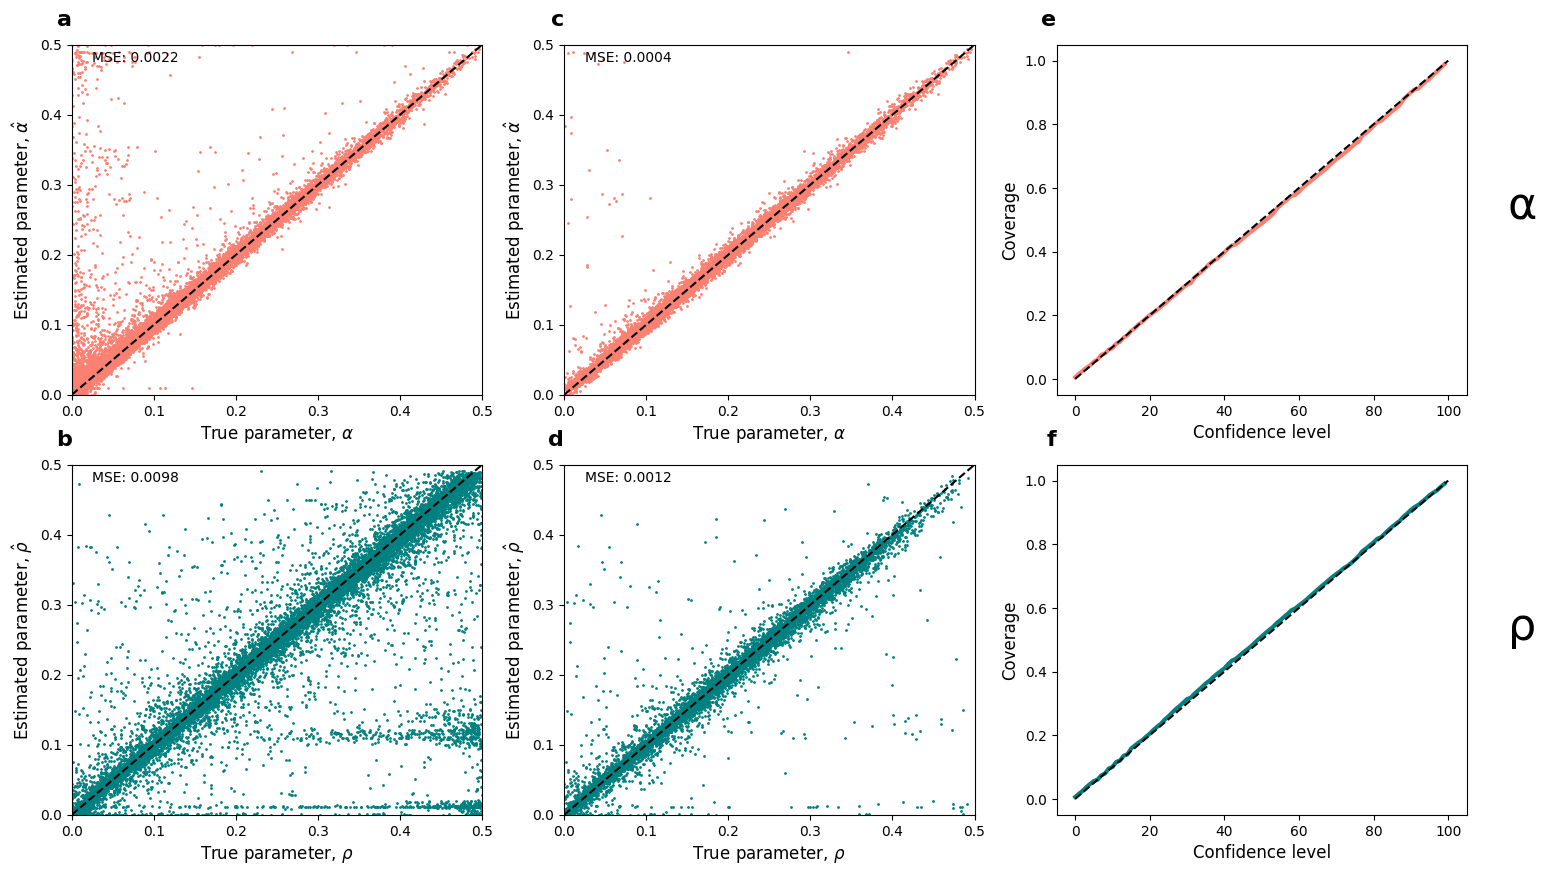

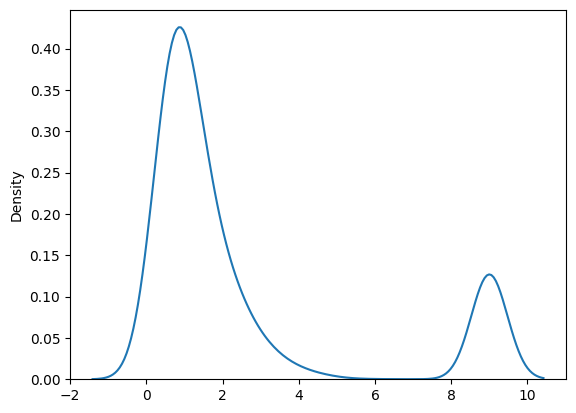

In [24]:
estemation_method = "C"
l_rate = [0.01,1]
min_diff = 0.07
# Function to plot the graphs
data = datasets[estemation_method][0]
min_rate, max_rate = l_rate
filtered_data = data[(data["left_parents"] >= min_rate) & (data["left_offsprings"]>= min_rate) & 
                        (data["left_parents"] <= max_rate) & (data["left_offsprings"] <= max_rate) &
                        (np.abs(data["R|RR - R|LL"]) >=min_diff)]
print(f"Filtered {len(data) - len(filtered_data)} datasets")
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

ax11 = axs[0,0]
ax11.text(0, 1.1, 'a', transform=ax11.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax12 = axs[1,0]
ax12.text(0, 1.1, 'b', transform=ax12.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

diff_α = data[["true_α","est_α"]].values
diff_ρ = data[["true_ρ","est_ρ"]].values    

ax11.scatter(diff_α[:, 0], diff_α[:, 1], label="α", s=1, color="salmon")
ax11.plot([0, 0.5], [0, 0.5], "--", color="black")
ax11.set_xlim(0, 0.5)
ax11.set_ylim(0, 0.5)
ax11.set_xlabel("True parameter, $α$", fontsize=fontx)
ax11.set_ylabel("Estimated parameter, $\hat{α}$", fontsize=fonty)

ax12.scatter(diff_ρ[:, 0], diff_ρ[:, 1],  label="ρ", s=1, color="teal")
ax12.plot([0, 0.5], [0, 0.5], "--", color="black")
ax12.set_xlim(0, 0.5)
ax12.set_xlabel("True parameter, $ρ$", fontsize=fontx)
ax12.set_ylabel('Estimated parameter, $\hat{ρ}$', fontsize=fonty)
ax12.set_ylim(0, 0.5)

mse_α = np.mean((diff_α[:, 0] - diff_α[:,1]) ** 2)
ax11.text(0.05, 0.95, f'MSE: {np.around(mse_α, 4)}', fontsize=10, color='black', transform=ax11.transAxes)
mse_ρ = np.mean((diff_ρ[:,0] - diff_ρ[:,1]) ** 2)
ax12.text(0.05, 0.95, f'MSE: {np.around(mse_ρ,4)}', fontsize=10, color='black', transform=ax12.transAxes)

# General params
diff_α = filtered_data[["true_α","est_α"]].values
diff_ρ = filtered_data[["true_ρ","est_ρ"]].values    
ax21 = axs[0,1]
ax22 = axs[1, 1]
ax21.scatter(diff_α[:, 0], diff_α[:, 1], label="α", s=1, color="salmon")
ax21.plot([0, 0.5], [0, 0.5], "--", color="black")
ax21.set_xlim(0, 0.5)
ax21.set_ylim(0, 0.5)
ax21.set_xlabel("True parameter, $α$", fontsize=fontx)
ax21.set_ylabel("Estimated parameter, $\hat{α}$", fontsize=fonty)
ax21.text(0, 1.1, 'c', transform=ax21.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

ax22.scatter(diff_ρ[:, 0], diff_ρ[:, 1],  label="ρ", s=1, color="teal")
ax22.plot([0, 0.5], [0, 0.5], "--", color="black")
ax22.set_xlim(0, 0.5)
ax22.set_xlabel("True parameter, $ρ$", fontsize=fontx)
ax22.set_ylabel('Estimated parameter, $\hat{ρ}$', fontsize=fonty)
ax22.set_ylim(0, 0.5)
ax22.text(0, 1.1, 'd', transform=ax22.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

mse_α = np.mean((diff_α[:, 0] - diff_α[:,1]) ** 2)
ax21.text(0.05, 0.95, f'MSE: {np.around(mse_α, 4)}', fontsize=10, color='black', transform=ax21.transAxes)
mse_ρ = np.mean((diff_ρ[:,0] - diff_ρ[:,1]) ** 2)
ax22.text(0.05, 0.95, f'MSE: {np.around(mse_ρ,4)}', fontsize=10, color='black', transform=ax22.transAxes)


# Coverage analysis
ax31 = axs[0, 2]
ax31.plot(np.arange(0,100), np.array([np.sum(filtered_data[f"conf_α_{99-i}"].values) for i in range(100)])/len(filtered_data), color='salmon', lw=3)
ax31.plot([0,100], [0,1], color='black', linestyle='--')
ax31.set_xlabel("Confidence level", fontsize=fontx)
ax31.set_ylabel("Coverage", fontsize=fonty)
ax31.text(0, 1.1, 'e', transform=ax31.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

ax32 = axs[1, 2]
ax32.plot(np.arange(0,100), np.array([np.sum(filtered_data[f"conf_ρ_{99-i}"].values) for i in range(100)])/len(filtered_data), color='teal', lw=3)
ax32.plot([0,100], [0,1], color='black', linestyle='--')
ax32.set_xlabel("Confidence level", fontsize=fontx)
ax32.set_ylabel("Coverage", fontsize=fonty)
ax32.text(0, 1.1, 'f', transform=ax32.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

ax31.text(1.1, 0.5, "α", fontsize=32, transform=ax31.transAxes)

ax32.text(1.1, 0.5, "ρ", fontsize=32, transform=ax32.transAxes)
plt.show()

cn = filtered_data["cn_true"].values
cn[~np.isfinite(cn)] =1e9
sns.kdeplot(np.log10(cn))
plt.show()